# 驗證模型的各項指標

參考文件
1. http://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html
2. https://blog.csdn.net/cherdw/article/details/55813071
3. http://alexkong.net/2013/06/introduction-to-auc-and-roc/

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import pandas as pd
import numpy as np
%matplotlib inline

In [63]:
from itertools import cycle
import itertools
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn import svm, datasets

##  範例
取得資料集，目標製作一個二元分類器

In [4]:
iris = datasets.load_iris()
X = iris.data
Y = iris.target

將Y轉乘one-hot vector

In [5]:
Y_2 = label_binarize(Y, classes=[0, 1, 2])
n_classes = Y_2.shape[1]
print("n_classes:%d"%n_classes)

n_classes:3


無聊增加800個沒意義的變數，讓問題變更難一點，最後產出804個變數(features)

In [6]:
random_state = np.random.RandomState(0)
n_samples, n_features = X.shape
print("n_samples:%d, n_features:%d"%X.shape)
X_2 = np.c_[X, random_state.randn(n_samples, 200 * n_features)]
pd.DataFrame(X_2).head()

n_samples:150, n_features:4


,0,1,2,3,4,5,6,7,8,9,...,794,795,796,797,798,799,800,801,802,803
0,5.1,3.5,1.4,0.2,1.764052,0.400157,0.978738,2.240893,1.867558,-0.977278,...,-0.757871,-0.050084,-0.897401,1.312470,-0.858972,-0.898942,0.074586,-1.077099,-0.424663,-0.829965
1,4.9,3.0,1.4,0.2,1.411172,0.785804,-0.057470,-0.391217,0.940918,0.405204,...,-1.116950,-0.035297,0.241204,1.127784,0.881131,1.032989,-0.923912,1.412152,-1.380431,-0.535915
2,4.7,3.2,1.3,0.2,0.430771,-0.149892,-1.006037,-0.821550,-1.548254,0.531975,...,-0.110591,-0.432432,1.077037,-0.224827,-0.576242,0.574609,-0.489828,0.658802,-0.596917,-0.222959
3,4.6,3.1,1.5,0.2,0.152177,-0.374126,-0.013451,0.815472,0.410602,0.480970,...,0.847408,-0.198720,1.575307,0.849115,-1.228895,0.888394,-0.516487,-0.083326,0.131054,-0.879096
4,5.0,3.6,1.4,0.2,-1.333342,0.367784,-1.388233,-2.575203,-0.836106,0.331092,...,-1.468367,0.576479,0.065306,-0.773513,0.394948,-0.503890,1.779559,-0.030572,1.577088,-0.812802


分割資料為 train 與 test 資料集，比例為0.5,0.5，平均75,75筆

In [7]:
X_train, X_test, Y_train, Y_test = train_test_split(X_2, Y_2, test_size=.5,random_state=0)
X_test.shape

(75, 804)

建立模型

In [8]:
classifier = OneVsRestClassifier(svm.SVC(kernel='linear', probability=True,random_state=random_state))
model = classifier.fit(X_train, Y_train)

取得score

In [10]:
# 這是取得SVM模型，每一個點到 hyper-plate的距離
Y_dist = model.decision_function(X_test)

In [11]:
Y_score = model.predict_proba(X_test)

In [12]:
Y_predict = model.predict(X_test)

計算作圖資料

In [16]:
fpr = dict()
tpr = dict()
roc_auc = dict()
# 針對不同class 給予不同的作圖
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(Y_test[:, i], Y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
# 其中 np.ravel() 就是做 flatten但不做變數clone，直接回傳reference
fpr["micro"], tpr["micro"], _ = roc_curve(Y_test.ravel(), Y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [18]:
roc_auc

{0: 0.9118165784832452,
 1: 0.3970370370370371,
 2: 0.7859477124183007,
 'micro': 0.720088888888889}

In [19]:
roc_auc["micro"]

0.720088888888889

### 作圖

- FPR = 預測發生，佔整體不預測發生的比率，表示錯誤預警 = NP / N
- TPR = 預測發生，佔整體發生的比率，表示確實預警率 = TP / P
- 最理想狀況 (FPR,TPR) = (0,1), 但是最糟糕就是 (FPR,TPR) = (1,0), 然後全部預測不會發生就是(0,0) 預測全部發生就會是(1,1)
- 所以最理想的預測就是整個曲線越往左上越好
- 基本上在AUC上，y = x (AUC=0.5) 幾乎就是隨機作圖的成果，任一個模型應該都會是比這個好，因為反指標就逆向拿來做就可以了

In [46]:
cla = 0

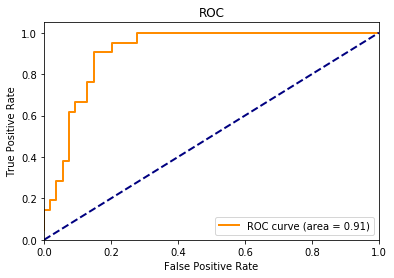

In [47]:
plt.figure()
lw = 2
plt.plot(fpr[cla], tpr[cla], color='darkorange',lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[cla])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")
plt.show()

In [21]:
from sklearn.metrics import log_loss, recall_score, precision_score, accuracy_score,f1_score
from sklearn.metrics import roc_curve, precision_recall_curve, roc_auc_score

In [23]:
i = 0
y_test,y_test_p,y_test_v = Y_test[:, i], Y_score[:, i], Y_predict[:,i]

In [24]:
print('auc: %f'%roc_auc_score(y_test, y_test_p))

# Multiple classes
print('precision: %f'%precision_score(y_test, y_test_v))
print('recall: %f'%recall_score(y_test, y_test_v))
print('accuracy: %f'%accuracy_score(y_test, y_test_v))
print('f1_score: %f'%f1_score(y_test, y_test_v))

auc: 0.911817
precision: 0.733333
recall: 0.523810
accuracy: 0.813333
f1_score: 0.611111


## K-S
1. https://zhuanlan.zhihu.com/p/25993786
2. http://www.cnblogs.com/huadongw/p/6415447.html

In [30]:
# a= np.random.rand(100)
bins = np.linspace(.0, 1.0, num=11,endpoint=True)
print("bins: %s"%bins)

bins: [0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]


In [49]:
#分類工作
data = {"Y":y_test,"Y_hat":y_test_p}
df = pd.DataFrame(data)
df['group'] = pd.cut(df["Y_hat"], bins= bins, right=False)
df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75 entries, 0 to 74
Data columns (total 3 columns):
Y        75 non-null int64
Y_hat    75 non-null float64
group    75 non-null category
dtypes: category(1), float64(1), int64(1)
memory usage: 1.5 KB


In [32]:
df3 = pd.pivot_table(df.sort_values(by='group'),values = ['group'],index='group',columns='Y',aggfunc=len,fill_value=0)
df4 = np.cumsum(df3)
df5 = df4/df4.max(axis=0)
ks = np.max(abs(df5.iloc[:,0] - df5.iloc[:,1]))
print('ks: %0.2f'%ks)

ks: 0.75


In [43]:
ind = abs(df5.iloc[:,0] - df5.iloc[:,1]).values.argmax()
ind

3

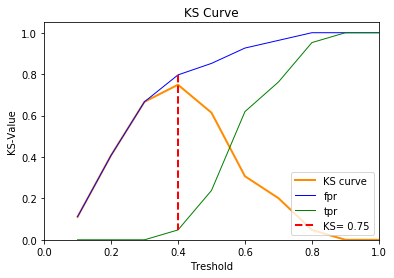

In [45]:
plt.figure()
#線寬
lw = 2
plt.plot(bins[1:],abs(df5.iloc[:,0] - df5.iloc[:,1]), color='darkorange',lw=lw, label='KS curve')
plt.plot(bins[1:], df5.iloc[:,0].reset_index(drop=True), color='blue',lw=1, label='fpr')
plt.plot(bins[1:], df5.iloc[:,1].reset_index(drop=True), color='green',lw=1, label='tpr')
plt.plot([bins[ind+1],bins[ind+1]], [df5.iloc[ind,0],df5.iloc[ind,1]], color='red', lw=lw, linestyle='--',label='KS= %0.2f'%ks)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Treshold')
plt.ylabel('KS-Value')
plt.title('KS Curve')
plt.legend(loc="lower right")
plt.show()

## Confusion Matrix


In [50]:
from sklearn.metrics import confusion_matrix

In [57]:

cfm = confusion_matrix(y_test, y_test_v)
print(cfm)

[[50  4]
 [10 11]]


多元處理尚未處理:
https://machinelearningmastery.com/how-to-one-hot-encode-sequence-data-in-python/

In [59]:
# http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[50  4]
 [10 11]]


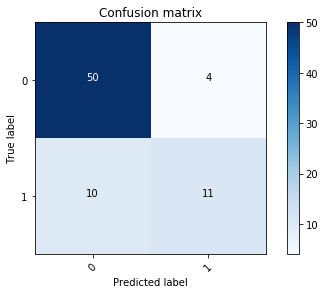

In [64]:
plot_confusion_matrix(cfm,classes=[0,1])